In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Super resolution data

In [2]:
from fastai.conv_learner import *
from pathlib import Path
torch.cuda.set_device(0)

torch.backends.cudnn.benchmark=True

In [3]:
PATH = Path('data/hollywood')
PATH_TRN = PATH

In [4]:
files = PATH.glob('*.jpeg')

In [5]:
filenames = [f.name for f in files]

In [6]:
filenames[:10]

['r837080_c359207.jpeg',
 'r837048_c359238.jpeg',
 'r837076_c359203.jpeg',
 'r837040_c359207.jpeg',
 'r837029_c359162.jpeg',
 'r837006_c359268.jpeg',
 'r836967_c359228.jpeg',
 'r836944_c359306.jpeg',
 'r837034_c359286.jpeg',
 'r836930_c359283.jpeg']

In [7]:
len(filenames)

22800

In [8]:
np.random.seed(42)
keep_pct = 1.
# keep_pct = 0.02
keeps = np.random.rand(len(filenames)) < keep_pct
fnames = np.array(filenames, copy=False)[keeps]

In [9]:
fnames

array(['r837080_c359207.jpeg', 'r837048_c359238.jpeg', 'r837076_c359203.jpeg', ..., 'r837060_c359236.jpeg',
       'r836938_c359242.jpeg', 'r837057_c359293.jpeg'], dtype='<U20')

In [10]:
arch = vgg16
sz_lr = 64

In [11]:
scale, bs = 2, 64
# scale,bs = 4, 32
sz_hr = sz_lr*scale

In [11]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
        
    def get_y(self, i):
        return open_image(os.path.join(self.path, self.y[i]))
    
    def get_c(self): 
        return 0

In [12]:
aug_tfms = [RandomDihedral(tfm_y=TfmType.PIXEL)]

In [13]:
val_idxs = get_cv_idxs(len(fnames), val_pct=min(0.01/keep_pct, 0.1))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), np.array(fnames))
len(val_x),len(trn_x)

(228, 22572)

In [15]:
tfms = tfms_from_model(arch, sz_lr, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms, sz_y=sz_hr)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH_TRN)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)

In [16]:
denorm = md.val_ds.denorm

In [14]:
def show_img(ims, idx, figsize=(5,5), normed=True, ax=None):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    if normed: ims = denorm(ims)
    else:      ims = np.rollaxis(to_np(ims),1,4)
    ax.imshow(np.clip(ims,0,1)[idx])
    ax.axis('off')

In [18]:
x,y = next(iter(md.val_dl))
x.size(),y.size()

(torch.Size([64, 3, 64, 64]), torch.Size([64, 3, 128, 128]))

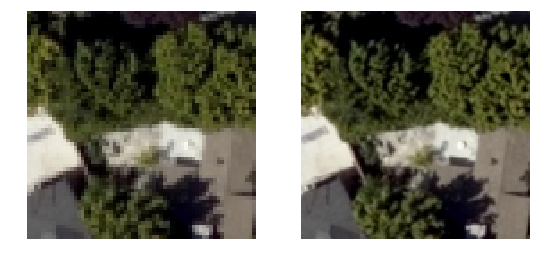

In [19]:
idx=1
fig,axes = plt.subplots(1, 2, figsize=(9,5))
show_img(x,idx, ax=axes[0])
show_img(y,idx, ax=axes[1])

In [20]:
x,y = next(iter(md.val_dl))
x.size(),y.size()

(torch.Size([64, 3, 64, 64]), torch.Size([64, 3, 128, 128]))

In [21]:
batches = [next(iter(md.aug_dl)) for i in range(9)]

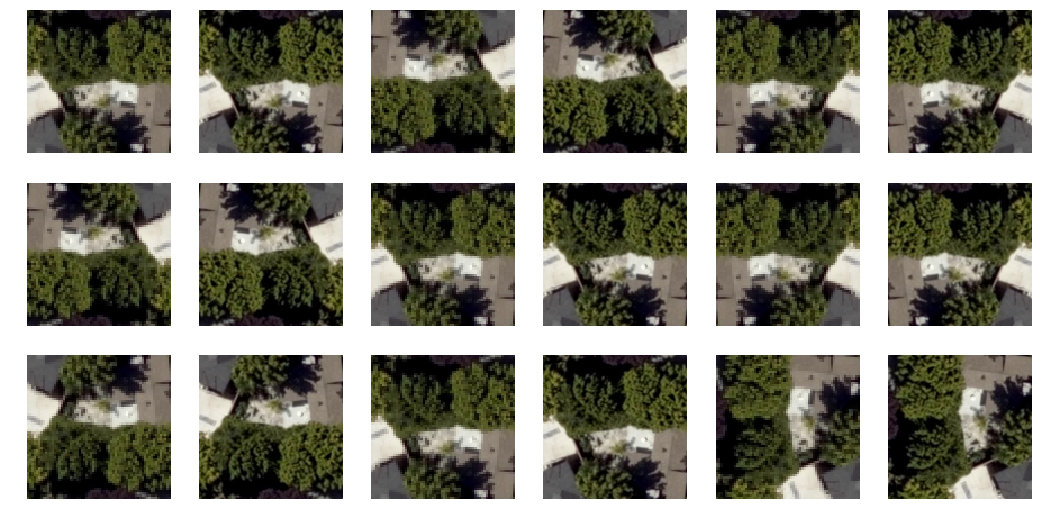

In [22]:
fig, axes = plt.subplots(3, 6, figsize=(18, 9))
for i,(x,y) in enumerate(batches):
    show_img(x,idx, ax=axes.flat[i*2])
    show_img(y,idx, ax=axes.flat[i*2+1])

## Model

In [15]:
def conv(ni, nf, kernel_size=3, actn=False):
    layers = [nn.Conv2d(ni, nf, kernel_size, padding=kernel_size//2)]
    if actn: 
        layers.append(nn.ReLU(True))
    return nn.Sequential(*layers)

In [16]:
class ResSequential(nn.Module):
    def __init__(self, layers, res_scale=1.0):
        super().__init__()
        self.res_scale = res_scale
        self.m = nn.Sequential(*layers)

    def forward(self, x): 
        return x + self.m(x) * self.res_scale

In [17]:
def res_block(nf):
    return ResSequential(
        [conv(nf, nf, actn=True), conv(nf, nf)],
        0.1)

In [18]:
def upsample(ni, nf, scale):
    layers = []
    for i in range(int(math.log(scale,2))):
        layers += [conv(ni, nf*4), nn.PixelShuffle(2)]
    return nn.Sequential(*layers)

In [19]:
class SrResnet(nn.Module):
    def __init__(self, nf, scale):
        super().__init__()
        features = [conv(3, 64)]
        for i in range(8): features.append(res_block(64))
        features += [conv(64,64), upsample(64, 64, scale),
                     nn.BatchNorm2d(64),
                     conv(64, 3)]
        self.features = nn.Sequential(*features)
        
    def forward(self, x):
        return self.features(x)

## Pixel loss

In [29]:
m = to_gpu(SrResnet(64, scale))
#m = nn.DataParallel(m, [0,2])
learn = Learner(md, SingleModel(m), opt_fn=optim.Adam)
learn.crit = F.mse_loss

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 33%|███▎      | 117/353 [01:28<02:57,  1.33it/s, loss=0.948]

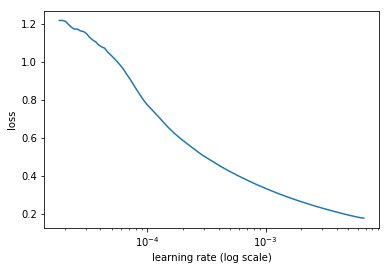

In [30]:
learn.lr_find(start_lr=1e-5, end_lr=10000)
learn.sched.plot()

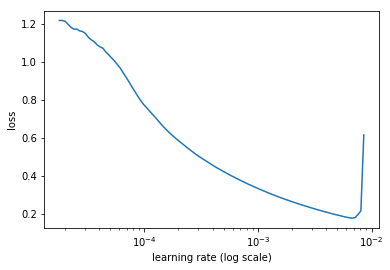

In [33]:
learn.sched.plot(n_skip_end=1)

In [34]:
lr=3e-3

In [35]:
learn.fit(lr, 1, cycle_len=1, use_clr_beta=(40,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  2%|▏         | 7/353 [00:05<04:54,  1.18it/s, loss=0.991]

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/rohit/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/rohit/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/rohit/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                                 
    0      0.008505   0.007881  



[array([0.00788])]

In [36]:
x,y = next(iter(md.val_dl))
preds = learn.model(VV(x))

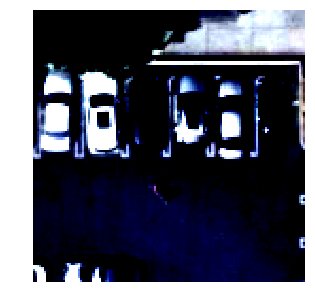

In [50]:
idx=10
show_img(y,idx,normed=False)

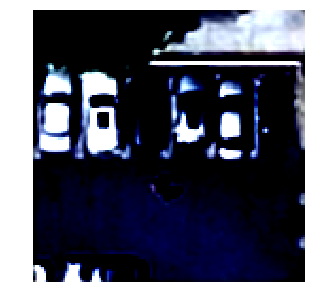

In [51]:
show_img(preds,idx,normed=False);

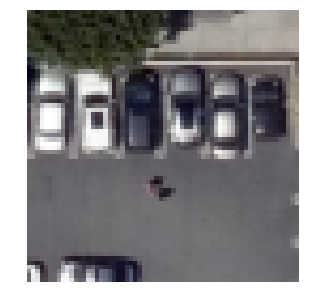

In [52]:
show_img(x,idx,normed=True);

In [53]:
x,y = next(iter(md.val_dl))
preds = learn.model(VV(x))

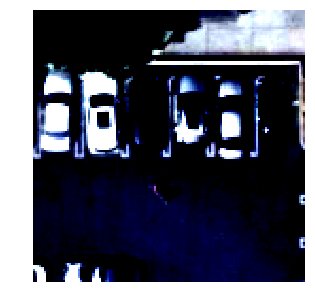

In [54]:
show_img(y,idx,normed=False)

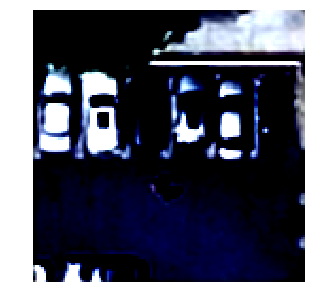

In [55]:
show_img(preds,idx,normed=False);

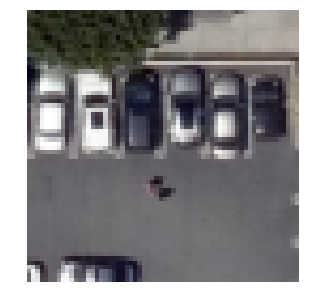

In [56]:
show_img(x,idx);

## Perceptual loss

In [20]:
def icnr(x, scale=2, init=nn.init.kaiming_normal):
    new_shape = [int(x.shape[0] / (scale ** 2))] + list(x.shape[1:])
    subkernel = torch.zeros(new_shape)
    subkernel = init(subkernel)
    subkernel = subkernel.transpose(0, 1)
    subkernel = subkernel.contiguous().view(subkernel.shape[0],
                                            subkernel.shape[1], -1)
    kernel = subkernel.repeat(1, 1, scale ** 2)
    transposed_shape = [x.shape[1]] + [x.shape[0]] + list(x.shape[2:])
    kernel = kernel.contiguous().view(transposed_shape)
    kernel = kernel.transpose(0, 1)
    return kernel

In [21]:
m_vgg = vgg16(True)

blocks = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.MaxPool2d)]
blocks, [m_vgg[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [22]:
vgg_layers = children(m_vgg)[:23]
m_vgg = nn.Sequential(*vgg_layers).cuda().eval()
set_trainable(m_vgg, False)

In [23]:
def flatten(x): return x.view(x.size(0), -1)

In [24]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()        

In [25]:
class FeatureLoss(nn.Module):
    def __init__(self, m, layer_ids, layer_wgts):
        super().__init__()
        self.m,self.wgts = m,layer_wgts
        self.sfs = [SaveFeatures(m[i]) for i in layer_ids]

    def forward(self, input, target, sum_layers=True):
        self.m(VV(target.data))
        res = [F.l1_loss(input,target)/100]
        targ_feat = [V(o.features.data.clone()) for o in self.sfs]
        self.m(input)
        res += [F.l1_loss(flatten(inp.features),flatten(targ))*wgt
               for inp,targ,wgt in zip(self.sfs, targ_feat, self.wgts)]
        if sum_layers: res = sum(res)
        return res
    
    def close(self):
        for o in self.sfs: o.remove()

In [73]:
m = SrResnet(64, scale)

In [74]:
conv_shuffle = m.features[10][0][0]
kernel = icnr(conv_shuffle.weight, scale=scale)
conv_shuffle.weight.data.copy_(kernel);

In [75]:
m = to_gpu(m)

In [76]:
learn = Learner(md, SingleModel(m), opt_fn=optim.Adam)

In [77]:
learn.freeze_to(999)

In [78]:
for i in range(10,13):
    set_trainable(m.features[i], True)

In [79]:
#m = nn.DataParallel(m, [0,2])
learn = Learner(md, SingleModel(m), opt_fn=optim.Adam)

In [80]:
learn.set_data(md)

In [81]:
learn.crit = FeatureLoss(m_vgg, blocks[:3], [0.2,0.7,0.1])

In [82]:
lr=6e-3
wd=1e-7

In [83]:
learn.lr_find(1e-4, 0.1, wds=wd, linear=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.051657   0.056051  



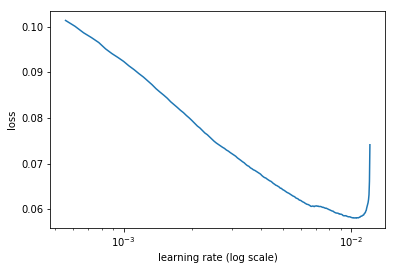

In [43]:
learn.sched.plot(n_skip_end=1)

In [84]:
learn.fit(lr, 1, cycle_len=2, wds=wd, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.035872   0.035014  
    1      0.032754   0.031875                                



[array([0.03187])]

In [85]:
learn.save('sr-samp0')

In [86]:
x,y = next(iter(md.val_dl))
preds = learn.model(VV(x))

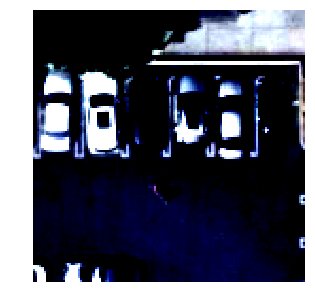

In [87]:
idx=10
show_img(y,idx,normed=False)

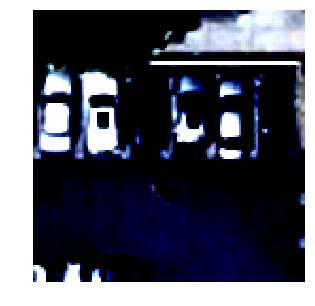

In [88]:
show_img(preds,idx,normed=False);

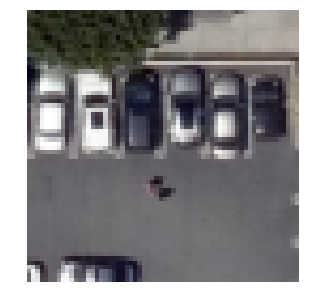

In [89]:
show_img(x,idx,normed=True);

### Multi-scale

In [43]:
# scale, bs = 2, 64
scale,bs = 4, 32
sz_hr = sz_lr*scale

In [44]:
tfms = tfms_from_model(arch, sz_lr, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms, sz_y=sz_hr)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH_TRN)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)

In [45]:
denorm = md.val_ds.denorm

In [46]:
x,y = next(iter(md.val_dl))
x.size(),y.size()

(torch.Size([32, 3, 64, 64]), torch.Size([32, 3, 256, 256]))

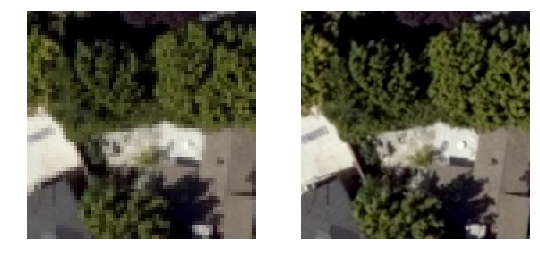

In [47]:
idx=1
fig,axes = plt.subplots(1, 2, figsize=(9,5))
show_img(x,idx, ax=axes[0])
show_img(y,idx, ax=axes[1])

In [48]:
batches = [next(iter(md.aug_dl)) for i in range(9)]

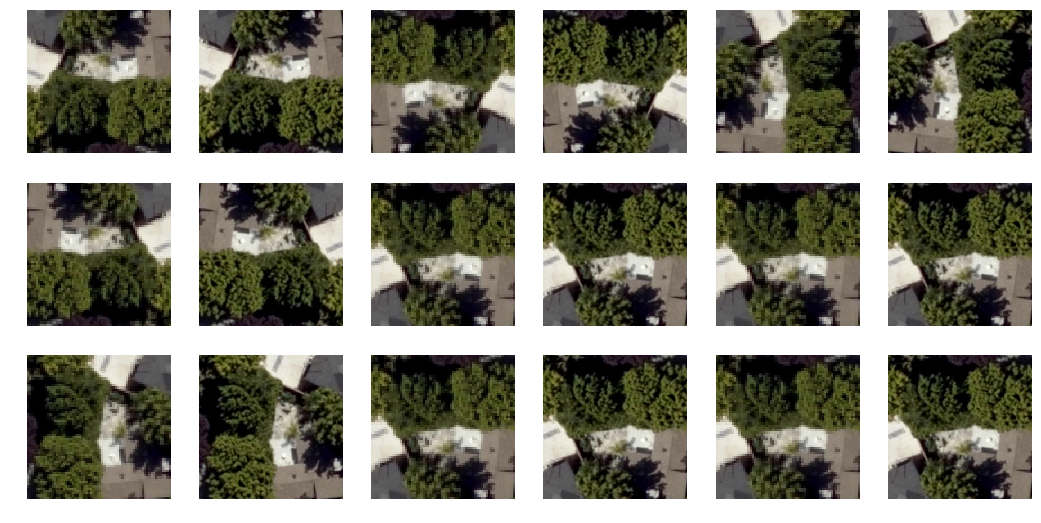

In [49]:
fig, axes = plt.subplots(3, 6, figsize=(18, 9))
for i,(x,y) in enumerate(batches):
    show_img(x,idx, ax=axes.flat[i*2])
    show_img(y,idx, ax=axes.flat[i*2+1])

In [50]:
m = SrResnet(64, scale)

In [51]:
m = to_gpu(m)

In [52]:
learn = Learner(md, SingleModel(m), opt_fn=optim.Adam)

In [53]:
t = torch.load(learn.get_model_path('sr-samp0'), map_location=lambda storage, loc: storage)
learn.model.load_state_dict(t, strict=False)

In [54]:
conv_shuffle = m.features[10][2][0]
kernel = icnr(conv_shuffle.weight, scale=scale)
conv_shuffle.weight.data.copy_(kernel);

In [55]:
learn.freeze_to(999)

In [56]:
for i in range(10,13): 
    set_trainable(m.features[i], True)

In [57]:
learn.set_data(md)

In [58]:
learn.crit = FeatureLoss(m_vgg, blocks[:3], [0.2,0.7,0.1])

In [59]:
lr=6e-3
wd=1e-7

In [60]:
learn.lr_find(1e-4, 0.1, wds=wd, linear=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 0/706 [00:00<?, ?it/s]                        


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/rohit/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/rohit/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/rohit/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                                
    0      0.054018   0.052937  



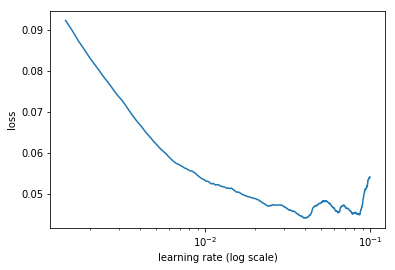

In [61]:
learn.sched.plot(n_skip_end=1)

In [62]:
lr=2e-2

In [63]:
learn.fit(lr, 1, cycle_len=2, wds=wd, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.040505   0.039749  
    1      0.039069   0.038088                                



[array([0.03809])]

In [64]:
learn.save('sr-samp1')

In [91]:
learn.load('sr-samp1')

In [65]:
lr=3e-3

In [66]:
learn.fit(lr, 1, cycle_len=1, wds=wd, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.038819   0.037895  



[array([0.0379])]

In [67]:
learn.save('sr-samp2')

In [68]:
learn.unfreeze()

In [40]:
learn.load('sr-samp2')

In [69]:
learn.fit(lr/3, 1, cycle_len=1, wds=wd, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.037328   0.036754  



[array([0.03675])]

In [70]:
learn.save('sr-final')

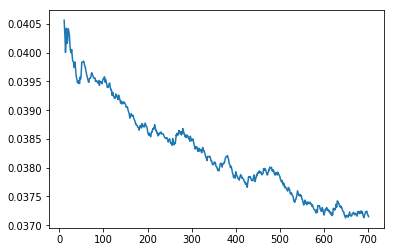

In [71]:
learn.sched.plot_loss()

In [74]:
def plot_ds_img(idx, ax=None, figsize=(7,7), normed=True):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    im = md.val_ds[idx][0]
    if normed: im = denorm(im)[0]
    else:      im = np.rollaxis(to_np(im),0,3)
    ax.imshow(im)
    ax.axis('off')

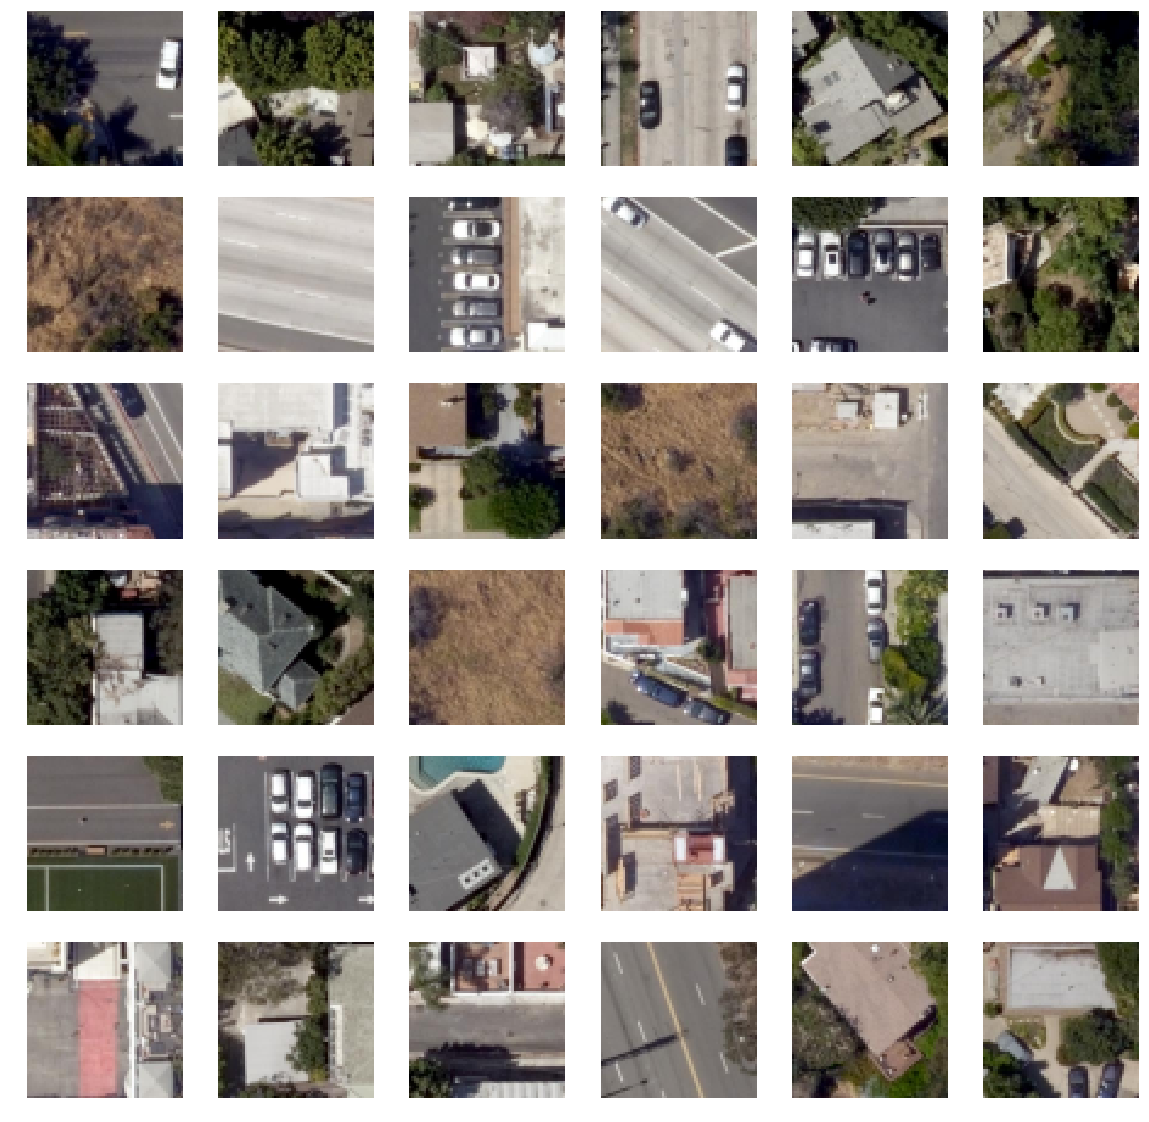

In [204]:
fig,axes=plt.subplots(6,6,figsize=(20,20))
for i,ax in enumerate(axes.flat): plot_ds_img(i, ax=ax, normed=True)

In [205]:
x,y=md.val_ds[10]

In [206]:
y=y[None]

In [207]:
learn.model.eval()
preds = learn.model(VV(x[None]))
x.shape,y.shape,preds.shape

((3, 64, 64), (1, 3, 256, 256), torch.Size([1, 3, 256, 256]))

In [208]:
learn.crit(preds, V(y), sum_layers=False)

[Variable containing:
 1.00000e-03 *
   1.1022
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  0
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  0
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  0
 [torch.cuda.FloatTensor of size 1 (GPU 0)]]

In [209]:
learn.crit.close()

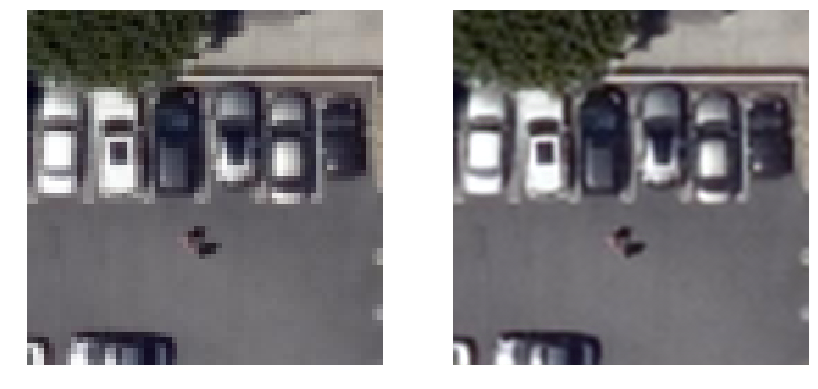

In [211]:
_,axes=plt.subplots(1,2,figsize=(14,7))
show_img(x[None], 0, ax=axes[0])
show_img(preds,0, normed=True, ax=axes[1])

### A few more interesting results!

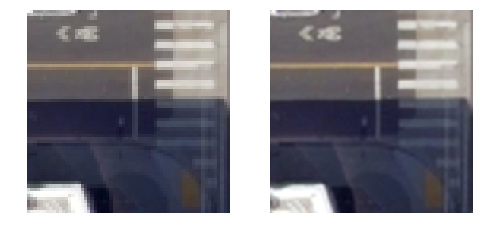

In [203]:
_,axes=plt.subplots(1,2,figsize=(8,4))
show_img(x[None], 0, ax=axes[0])
show_img(preds,0, normed=True, ax=axes[1])

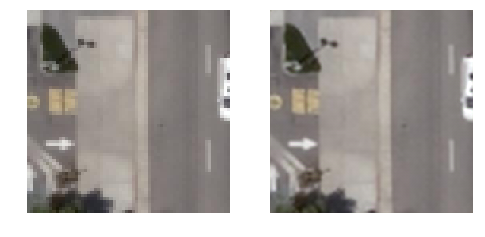

In [190]:
_,axes=plt.subplots(1,2,figsize=(8,4))
show_img(x[None], 0, ax=axes[0])
show_img(preds,0, normed=True, ax=axes[1])

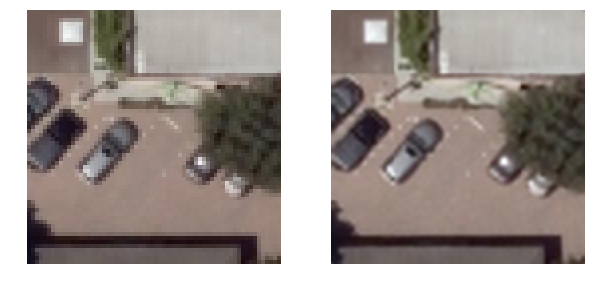

In [170]:
_,axes=plt.subplots(1,2,figsize=(10,5))
show_img(x[None], 0, ax=axes[0])
show_img(preds,0, normed=True, ax=axes[1])

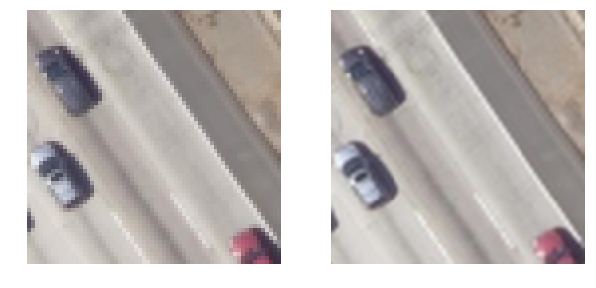

In [130]:
_,axes=plt.subplots(1,2,figsize=(10,5))
show_img(x[None], 0, ax=axes[0])
show_img(preds,0, normed=True, ax=axes[1])

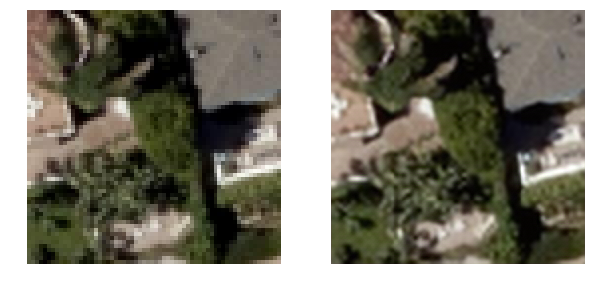

In [121]:
_,axes=plt.subplots(1,2,figsize=(10,5))
show_img(x[None], 0, ax=axes[0])
show_img(preds,0, normed=True, ax=axes[1])

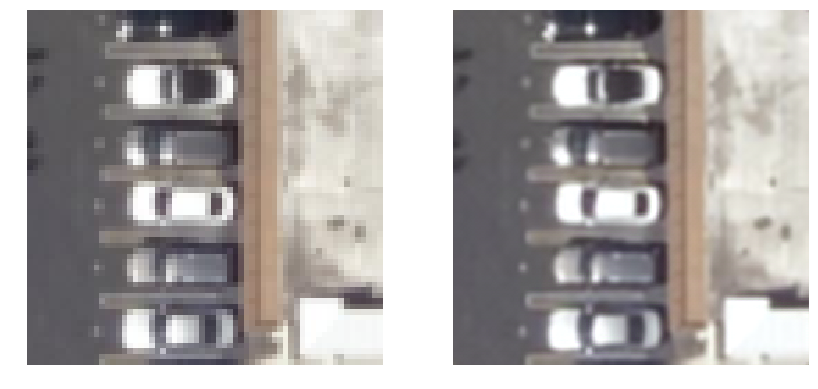

In [88]:
_,axes=plt.subplots(1,2,figsize=(14,7))
show_img(x[None], 0, ax=axes[0])
show_img(preds,0, normed=True, ax=axes[1])